# Imports

In [18]:
import tensorflow as tf
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import finananal as finan

from tensorflow.keras import layers
from tensorflow.keras import models

import pickle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Constants

In [19]:
TRAIN_SPLIT = 7000

# Tensorboard and Tensorflow prep.

In [20]:
# %load_ext tensorboard

In [21]:
# !rm -rf ./logs/ 

In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [23]:
tf.random.set_seed(666)

# Reading the files

In [24]:
sp_500 = pd.read_pickle(r'normalized/X_norm_1604_1closech.pkl')
sp_500 = np.array(sp_500, dtype = 'f')
sp_500.shape[1]

43

In [25]:
y_norm = pd.read_pickle(r'normalized/y_norm_1604_1closech.pkl')
y_norm = np.array(y_norm, dtype = 'f')

In [26]:
# sp_500 = np.array(finan.flattener(sp_500))
# type(sp_500)

# Creation of samples 

In [27]:
past_history = 45
future_target = 5
STEP = 1

x_train_single, y_train_single = finan.multivariate_data(sp_500, y_norm, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
x_val_single, y_val_single = finan.multivariate_data(sp_500, y_norm,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=False)

8089


In [28]:
x_train_single = np.array(x_train_single)
x_val_single = np.array(x_val_single)
y_train_single = np.array(y_train_single)
y_val_single = np.array(y_val_single)

In [29]:
y_train_single[0]

array([0.50837743, 0.48848966, 0.4934942 , 0.49192762, 0.48801103],
      dtype=float32)

In [30]:
cubes_val = x_val_single.shape[0]

In [31]:
cubes_train = x_train_single.shape[0]

In [32]:
x_train_1last= x_train_single.reshape(cubes_train,past_history,43,41,1)

In [34]:
x_val_1last= x_val_single.reshape(cubes_val,past_history,43,41,1)

In [35]:
type(x_train_single)

numpy.ndarray

In [36]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (45, 43, 41)


# Data that feed the DNN

In [37]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_1last, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_1last, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [38]:
train_data_single

<RepeatDataset shapes: ((None, 45, 43, 41, 1), (None, 5)), types: (tf.float32, tf.float32)>

In [39]:
x_train_single.shape[-2:]

(43, 41)

# DNN (CNN + LSTM)

In [58]:
multi_step_model = models.Sequential()

multi_step_model.add(layers.InputLayer(batch_input_shape=(None,past_history,43,41,1)))

multi_step_model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3)), name = 'CNN1'))
multi_step_model.add(layers.TimeDistributed(layers.MaxPooling2D(2,2), name = 'Pooling1'))
multi_step_model.add(tf.keras.layers.TimeDistributed(layers.Dropout(0.25), name = 'Drop1'))

multi_step_model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3)), name = 'CNN2'))
multi_step_model.add(layers.TimeDistributed(layers.MaxPooling2D(2,2), name = 'Pooling2'))
multi_step_model.add(tf.keras.layers.TimeDistributed(layers.Dropout(0.25), name = 'Drop2'))

multi_step_model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3)), name = 'CNN3'))
multi_step_model.add(layers.TimeDistributed(layers.MaxPooling2D(2,2), name = 'Pooling3'))
multi_step_model.add(tf.keras.layers.TimeDistributed(layers.Dropout(0.25), name = 'Drop3'))

multi_step_model.add(layers.TimeDistributed(layers.Flatten(), name = 'Flat'))

multi_step_model.add(layers.LSTM(128, return_sequences = True, dropout = 0.25, name = 'LSTM1'))
multi_step_model.add(layers.LSTM(64, dropout = 0.25, name = 'LSTM2'))

multi_step_model.add(layers.Dense(future_target))

multi_step_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])

In [59]:
multi_step_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN1 (TimeDistributed)       (None, 45, 41, 39, 16)    160       
_________________________________________________________________
Pooling1 (TimeDistributed)   (None, 45, 20, 19, 16)    0         
_________________________________________________________________
Drop1 (TimeDistributed)      (None, 45, 20, 19, 16)    0         
_________________________________________________________________
CNN2 (TimeDistributed)       (None, 45, 18, 17, 32)    4640      
_________________________________________________________________
Pooling2 (TimeDistributed)   (None, 45, 9, 8, 32)      0         
_________________________________________________________________
Drop2 (TimeDistributed)      (None, 45, 9, 8, 32)      0         
_________________________________________________________________
CNN3 (TimeDistributed)       (None, 45, 7, 6, 64)     

In [60]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

multi_step_history = multi_step_model.fit(train_data_single, epochs=100,
                                            steps_per_epoch=3000,
                                            validation_data=val_data_single,
                                            validation_steps=150,
                                           callbacks=[tensorboard_callback])

Epoch 1/100
3000/3000 [==============================] - 91s 30ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0367 - mape: 8.1489 - val_loss: 0.0273 - val_mse: 0.0269 - val_mae: 0.1452 - val_mape: 265296.6562
Epoch 2/100
3000/3000 [==============================] - 89s 30ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0347 - mape: 7.7257 - val_loss: 0.0093 - val_mse: 0.0092 - val_mae: 0.0698 - val_mape: 490118.7188
Epoch 3/100
3000/3000 [==============================] - 90s 30ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0344 - mape: 7.6609 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0682 - val_mape: 507593.0625
Epoch 4/100
3000/3000 [==============================] - 90s 30ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0342 - mape: 7.5958 - val_loss: 0.0086 - val_mse: 0.0087 - val_mae: 0.0632 - val_mape: 526133.8125
Epoch 5/100
3000/3000 [==============================] - 89s 30ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0317 - mape: 6.9228 - val_loss: 0.0121 - val_mse: 0.0120 - 

3000/3000 [==============================] - 87s 29ms/step - loss: 8.2247e-05 - mse: 8.2233e-05 - mae: 0.0070 - mape: 1.4537 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0734 - val_mape: 434169.0938
Epoch 40/100
3000/3000 [==============================] - 87s 29ms/step - loss: 8.0243e-05 - mse: 8.0162e-05 - mae: 0.0069 - mape: 1.4362 - val_loss: 0.0115 - val_mse: 0.0114 - val_mae: 0.0774 - val_mape: 528945.9375
Epoch 41/100
3000/3000 [==============================] - 87s 29ms/step - loss: 7.8403e-05 - mse: 7.8351e-05 - mae: 0.0068 - mape: 1.4189 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0708 - val_mape: 462753.6562
Epoch 42/100
3000/3000 [==============================] - 87s 29ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0174 - mape: 3.8306 - val_loss: 0.0074 - val_mse: 0.0075 - val_mae: 0.0570 - val_mape: 518371.8125
Epoch 43/100
3000/3000 [==============================] - 86s 29ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0341 - mape: 7.6321 - val_loss: 0.0075 - va

3000/3000 [==============================] - 92s 31ms/step - loss: 6.0805e-04 - mse: 6.0771e-04 - mae: 0.0182 - mape: 3.7865 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0704 - val_mape: 575571.6250
Epoch 78/100
3000/3000 [==============================] - 90s 30ms/step - loss: 5.1104e-04 - mse: 5.1038e-04 - mae: 0.0168 - mape: 3.4873 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0721 - val_mape: 544847.0000
Epoch 79/100
3000/3000 [==============================] - 88s 29ms/step - loss: 5.2166e-04 - mse: 5.2096e-04 - mae: 0.0168 - mape: 3.4875 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0698 - val_mape: 524245.1562
Epoch 80/100
3000/3000 [==============================] - 92s 31ms/step - loss: 4.4710e-04 - mse: 4.4653e-04 - mae: 0.0158 - mape: 3.2717 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0703 - val_mape: 456518.9375
Epoch 81/100
3000/3000 [==============================] - 92s 31ms/step - loss: 6.4413e-04 - mse: 6.4421e-04 - mae: 0.0176 - mape: 3.6944 - val_l

In [44]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# multi_step_history = multi_step_model.fit(x = x_train_1last, y = y_train_single, epochs=25,
#                                             steps_per_epoch=1000,
#                                             validation_data=(x_val_1last, y_val_single),
#                                             validation_steps=100,
#                                            callbacks=[tensorboard_callback])

In [45]:
# def plot_train_history(history, title):
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     epochs = range(len(loss))

#     plt.figure()

#     plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
#     plt.title(title)
#     plt.legend()

#     plt.show()

In [61]:
def create_time_steps(length):
    return list(range(-length, 0))

In [62]:
# def show_plot(plot_data, delta, title):
#     labels = ['History', 'True Future', 'Model Prediction']
#     marker = ['.-', 'rx', 'go']
#     time_steps = create_time_steps(plot_data[0].shape[0])
#     if delta:
#         future = delta
#     else:
#         future = 0

#     plt.title(title)
#     for i, x in enumerate(plot_data):
#         if i:
#             plt.plot(future, plot_data[i], marker[i], markersize=10,
#                    label=labels[i])
#         else:
#             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
#     plt.legend()
#     plt.xlim([time_steps[0], (future+5)*2])
#     plt.xlabel('Time-Step')
#     return plt

In [63]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.ylim(0,1)
    plt.grid()
    plt.show()

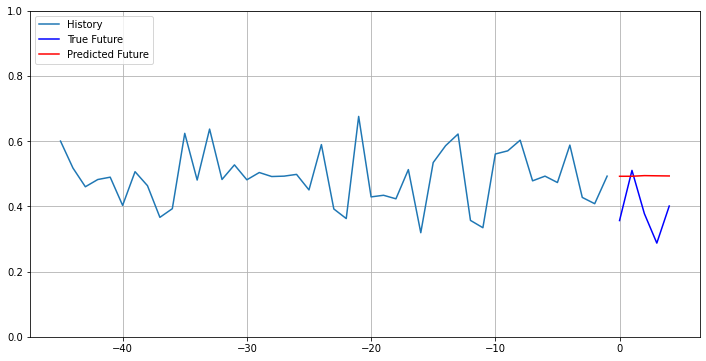

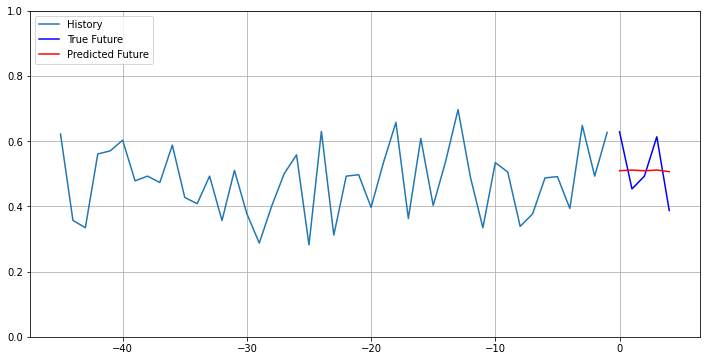

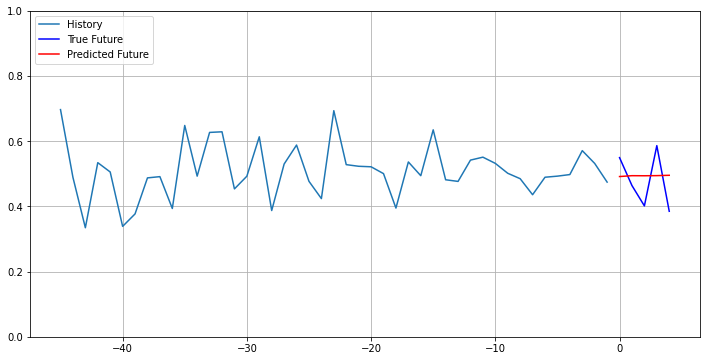

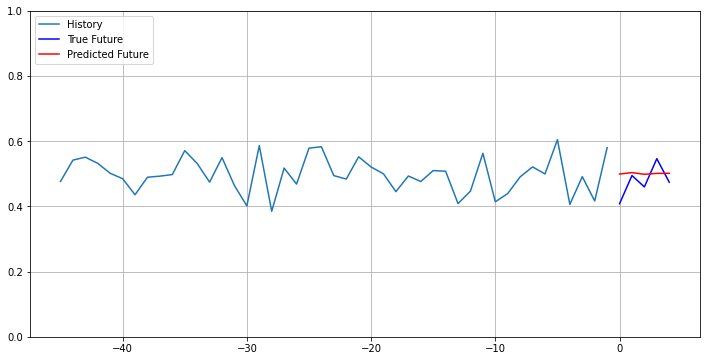

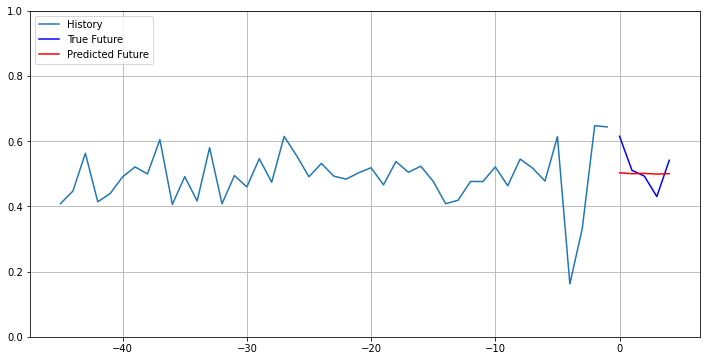

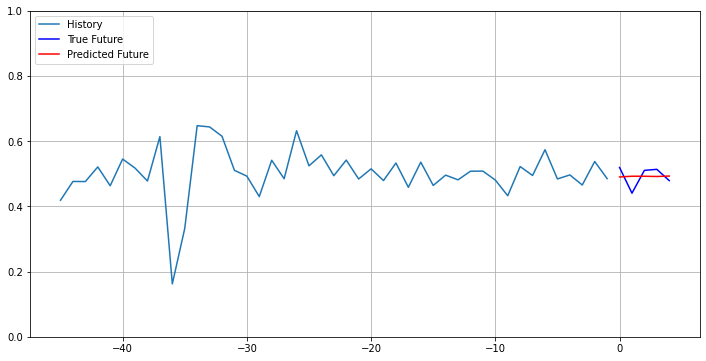

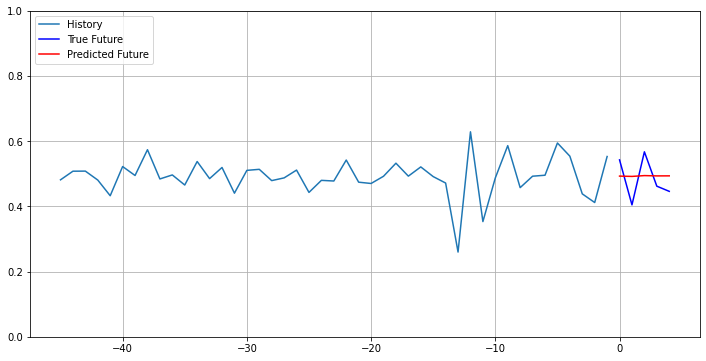

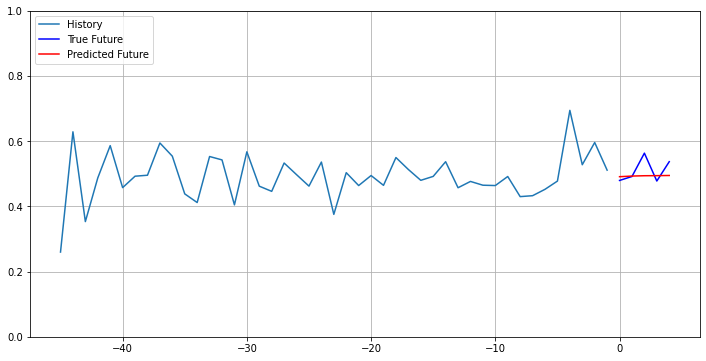

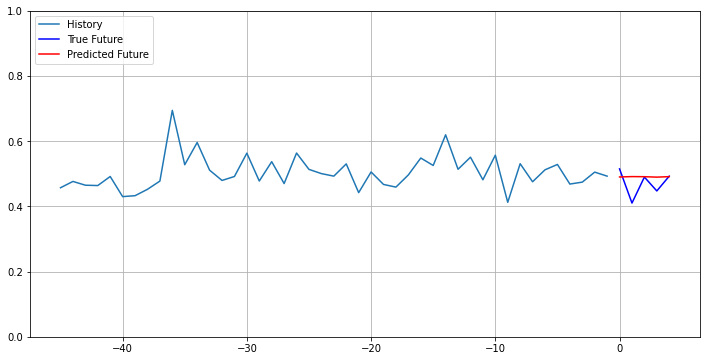

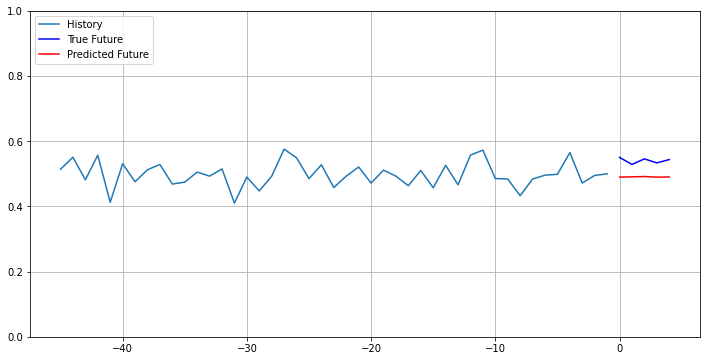

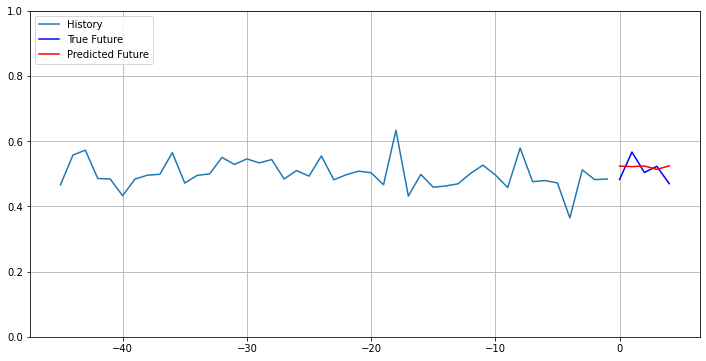

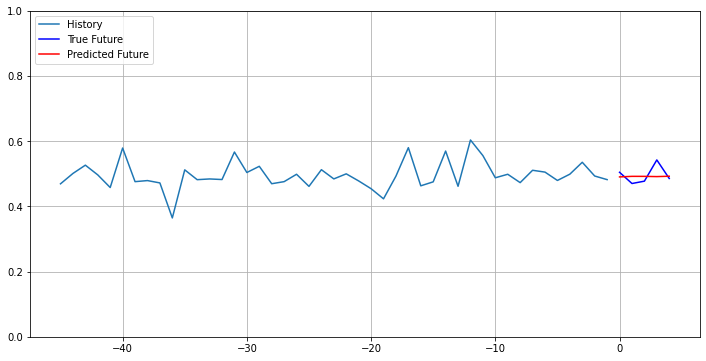

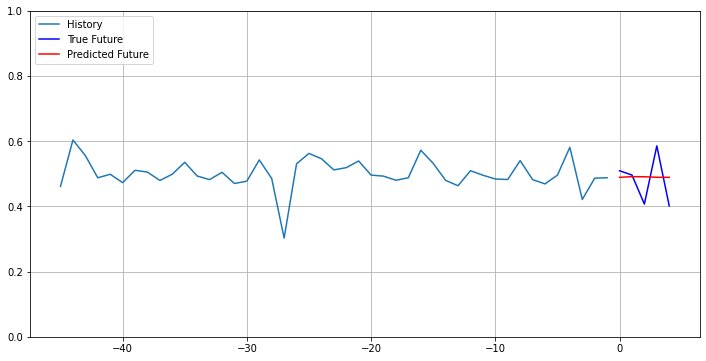

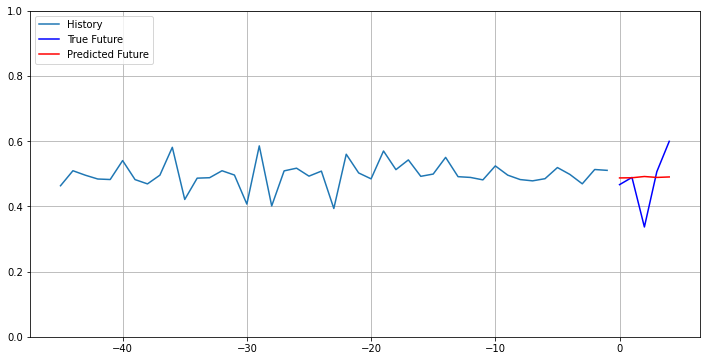

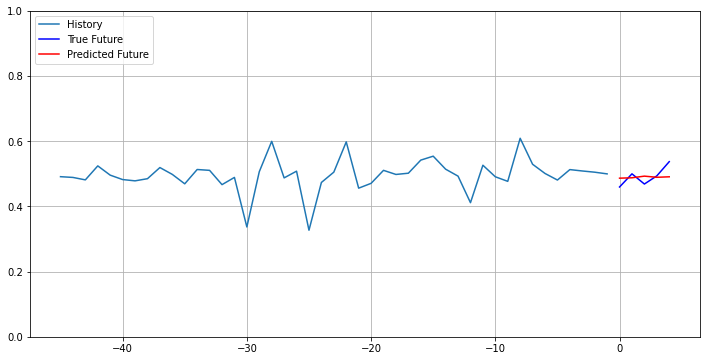

In [64]:
for x, y in val_data_single.take(15):
    vect = x[0]
    close = []
    for i in range(np.array(x).shape[1]):
        close.append(vect[i,0,2,0])
    np.array(close)
    multi_step_plot(close, y[0], multi_step_model.predict(x)[0])

In [65]:
multi_step_model.save('saved_model/sp500_all_LSTM_2_2304_closech') 

INFO:tensorflow:Assets written to: saved_model/sp500_all_LSTM_2_2304_closech/assets


In [66]:
# multi_step_model.score()

In [67]:
f = open("data_train_val/X_data_train_2_2304","wb")
pickle.dump(x_train_single,f)
f.close()

In [68]:
f = open("data_train_val/X_data_val_2_2304","wb")
pickle.dump(x_val_single,f)
f.close()

In [69]:
f = open("data_train_val/y_data_train_2_2304","wb")
pickle.dump(y_train_single,f)
f.close()

In [70]:
f = open("data_train_val/y_data_val_2_2304","wb")
pickle.dump(y_val_single,f)
f.close()